In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

In [2]:
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

### Проект: вариант 3
Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

#### Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

##### users_*.csv – информация о пользователях:

 - uid – идентификатор пользователя
 - age – возраст
 - attraction_coeff – коэффициент привлекательности (от 0 до 1000, (лайки/просмотры) * 1000)
 - coins – число монеток (внутренняя валюта)
 - country – страна  
 - visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
 - gender – пол
 - age_filter_start  – фильтр поиска, мин. значение 
 - age_filter_end  – фильтр поиска, макс. значение 
 - views_count – число полученных оценок 
 - was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
 - is_premium –  является ли премиум
 - total_revenue – нормированная выручка
 
##### transactions_*.csv – информация о платежах пользователей:

 - uid – идентификатор пользователя
 - country – страна
 - joined_at – дата и время регистрации
 - paid_at – дата и время покупки
 - revenue – нормированная выручка
 - payment_id – идентификатор платежа
 - from_page – откуда пользователь перешел на страницу оплаты
 - product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной,      coins – подписка за внутреннюю валюту, other_type – другое)
 

### 1. Введение

В этом проекте я буду смотреть на следующие метрики: конверсия пользователей (тех, кто купил премиум-подписку без пробной) и ARPU.

Использованные статистические методы: Хи-квадрат Пирсона, U-тест Манна-Уитни, H-тест  Краскела-Уоллиса

### 2. Загрузка и предобработка данных

In [3]:
# загружаю файлы из папочки

users_test = pd.read_csv('users_test.csv', sep=';')
users_conrol_1 = pd.read_csv('users_control_1.csv', sep=';')
users_conrol_2 = pd.read_csv('users_control_2.csv', sep=';')
transactions_test = pd.read_csv('transactions_test.csv', sep=';')
transactions_control_1 = pd.read_csv('transactions_control_1.csv', sep=';')
transactions_control_2 = pd.read_csv('transactions_control_2.csv', sep=';')

In [4]:
# а можно прямо с яндекс.диска

users_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/L8HxRYDn2l4h9A', sep=';')
users_conrol_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/TxOD_JxnkMd4mA', sep=';')
users_conrol_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YT6OWRK2cTWfLg', sep=';')
transactions_test = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3viYBnm7cyihkQ', sep=';')
transactions_control_1 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84jzzJeQ4tqVyg', sep=';')
transactions_control_2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/_pOo7mrDCZZMyA', sep=';')

In [5]:
transactions_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN


In [6]:
transactions_control_1 = transactions_control_1.dropna()

In [7]:
transactions_control_1

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial
373,892052106.0,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883.0,147.0,trial_vip_popup,trial_premium
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium
375,891458229.0,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305.0,19.0,menu,coins


In [8]:
transactions_control_2

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial
...,...,...,...,...,...,...,...,...
323,891985866,Belgium,2017-10-23 13:19:00,2017-10-30 15:35:00,16640,147,trial_vip_popup,trial_premium
324,891491145,United States of America,2017-02-11 18:13:00,2017-09-11 20:32:00,12727,147,send_message,trial_premium
325,892053750,United States of America,2017-10-22 00:46:00,2017-10-28 08:17:00,1261,19,autorefill,coins
326,891668253,Chile,2017-10-29 23:08:00,2017-11-15 00:57:00,9997,147,trial_vip_popup,trial_premium


In [9]:
transactions_control_2.head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


In [10]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [11]:
users_test.describe()

,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,4.308000e+03,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000,408.0,157.0,4308.000000
mean,8.917437e+08,31.889276,316.411328,229.836735,0.953110,26.701486,38.248839,50.391133,1.0,1.0,534.080316
std,4.547670e+05,10.245287,323.373725,1205.819471,0.211427,9.390851,15.344562,318.676437,0.0,0.0,4371.682632
min,8.910511e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,8.913621e+08,25.000000,0.000000,4.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,8.917290e+08,30.000000,250.000000,9.000000,1.000000,24.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,8.920952e+08,38.000000,520.250000,72.000000,1.000000,32.000000,44.000000,22.000000,1.0,1.0,0.000000
max,9.051586e+08,99.000000,1000.000000,8466.000000,1.000000,96.000000,102.000000,12831.000000,1.0,1.0,129870.000000


In [12]:
users_test.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


In [13]:
# Заменяю пустые значения нулями

users_test.fillna(0, inplace=True)
users_conrol_1.fillna(0, inplace=True)
users_conrol_2.fillna(0, inplace=True)

In [14]:
transactions_control_1.from_page.unique()

array(['trial_vip_popup', 'none', 'sympathy', 'empty_likes', 'gifts',
       'dating', 'menu', 'left_sidebar_menu', 'autorefill',
       'empty_admins', 'promo_09', 'coins_popup', 'autoreply_message',
       'fans', 'refund_VP', 'popular_users_block', 'refung_AP',
       'ad_to_photo', 'no_sympathy', 'send_message', 'popular_users_chat',
       'user_profile', 'admins', 'refund_WP', 'super_popup'], dtype=object)

In [15]:
users_test.groupby('total_revenue').agg({'uid' : 'count'})

,uid
total_revenue,
0,4162
624,1
741,1
897,2
1261,1
...,...
61789,1
75647,1
95823,1


In [16]:
users_conrol_1.groupby('total_revenue').agg({'uid' : 'count'})

,uid
total_revenue,
0,4148
26,1
728,1
767,1
962,1
...,...
60333,1
63024,1
63037,1


In [17]:
users_conrol_1.query('total_revenue == 486330')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330


In [18]:
# Пользователь с uid  486330 - явный выброс, удалим из выборки
users_conrol_1_cl = users_conrol_1.query('uid != 892333905')

In [19]:
users_conrol_2.groupby('total_revenue').agg({'uid' : 'count'})

,uid
total_revenue,
0,4077
481,1
728,1
897,1
1261,1
...,...
28119,1
30849,1
34125,1


In [20]:
# Проверка распределений на нормльность (не пройдена)
print (ss.shapiro(users_test.total_revenue.sample(1000, random_state=17)))
print (ss.shapiro(users_conrol_1.total_revenue.sample(1000, random_state=17)))
print (ss.shapiro(users_conrol_2.total_revenue.sample(1000, random_state=17)))

ShapiroResult(statistic=0.09746277332305908, pvalue=0.0)
ShapiroResult(statistic=0.1562764048576355, pvalue=0.0)
ShapiroResult(statistic=0.1734728217124939, pvalue=0.0)


### 3. Расчет конверсии

Буду расчитывать конверсию в премиум-подписку без пробной, т.к. цена на остальные продукты осталась прежней.
Меня интересуют пользователи с типом продукта premium_no_trial

Распределения в выборках не нормальны, поэтому буду использовать критерий Хи-квадрат

In [21]:
# Формирую новый датафрейм для тестовой группы

premium_test = (
    users_test[['uid', 'was_premium', 'is_premium']] 
          .merge(transactions_test.query('product_type == "trial_premium" or product_type == "premium_no_trial"')
                                         [['uid','product_type']], how='left', on = 'uid')
          .fillna(0)
          .pivot_table(values="is_premium", index = 'uid', columns = "product_type", aggfunc=np.sum, fill_value=0)
)
premium_test

product_type,0,premium_no_trial,trial_premium
uid,,,
891051147,0,0,0
891052710,0,0,0
891053094,0,0,0
891054294,0,0,0
891054594,0,0,0
...,...,...,...
892440117,0,0,0
892440651,0,0,0
892440774,0,0,0


In [22]:
premium_test['is_premium_no_trial'] = premium_test.premium_no_trial.apply(lambda x: 'yes' if x > 0 else 'no')
premium_test['group'] = 'test'
premium_test = premium_test.rename_axis('index', axis = 1).reset_index()[['uid', 'is_premium_no_trial', 'group']]
premium_test

index,uid,is_premium_no_trial,group
0,891051147,no,test
1,891052710,no,test
2,891053094,no,test
3,891054294,no,test
4,891054594,no,test
...,...,...,...
4303,892440117,no,test
4304,892440651,no,test
4305,892440774,no,test
4306,892440783,no,test


In [23]:
# Делаю то же самое для двух контрольных групп

In [24]:
premium_ctrl_1 = (
    users_conrol_1[['uid', 'was_premium', 'is_premium']] 
          .merge(transactions_control_1.query('product_type == "trial_premium" or product_type == "premium_no_trial"')
                                         [['uid','product_type']], how='left', on = 'uid')
          .fillna(0)
          .pivot_table(values="is_premium", index = 'uid', columns = "product_type", aggfunc=np.sum, fill_value=0)
)

In [25]:
premium_ctrl_2 = (
    users_conrol_2[['uid', 'was_premium', 'is_premium']] 
          .merge(transactions_control_2.query('product_type == "trial_premium" or product_type == "premium_no_trial"')
                                         [['uid','product_type']], how='left', on = 'uid')
          .fillna(0)
          .pivot_table(values="is_premium", index = 'uid', columns = "product_type", aggfunc=np.sum, fill_value=0)
)

In [26]:
premium_ctrl_1['is_premium_no_trial'] = premium_ctrl_1.premium_no_trial.apply(lambda x: 'yes' if x == 1 else 'no')
premium_ctrl_1['group'] = 'control_1'
premium_ctrl_1 = premium_ctrl_1.rename_axis('index', axis = 1).reset_index()[['uid', 'is_premium_no_trial', 'group']]
premium_ctrl_1

index,uid,is_premium_no_trial,group
0,891050997,no,control_1
1,891051552,no,control_1
2,891051606,no,control_1
3,891052698,no,control_1
4,891053274,no,control_1
...,...,...,...
4335,892439349,no,control_1
4336,892439700,no,control_1
4337,892439976,no,control_1
4338,892440600,no,control_1


In [27]:
premium_ctrl_2['is_premium_no_trial'] = premium_ctrl_2.premium_no_trial.apply(lambda x: 'yes' if x == 1 else 'no')
premium_ctrl_2['group'] = 'control_2'
premium_ctrl_2 = premium_ctrl_2.rename_axis('index', axis = 1).reset_index()[['uid', 'is_premium_no_trial', 'group']]
premium_ctrl_2

index,uid,is_premium_no_trial,group
0,891050916,no,control_2
1,891051075,no,control_2
2,891051960,no,control_2
3,891052416,no,control_2
4,891053088,no,control_2
...,...,...,...
4259,892439346,no,control_2
4260,892439454,no,control_2
4261,892439616,no,control_2
4262,911001330,no,control_2


In [28]:
# Собираю все в итоговый датафрейм (очень люблю датафреймы)

In [29]:
df_for_chi = pd.concat([premium_test, premium_ctrl_1, premium_ctrl_2])
df_for_chi_1 = pd.concat([premium_test, premium_ctrl_1])
df_for_chi_2 = pd.concat([premium_test, premium_ctrl_2])
df_for_chi_ct = pd.concat([premium_ctrl_2, premium_ctrl_1])

In [30]:
pd.crosstab(df_for_chi.group, df_for_chi.is_premium_no_trial)

is_premium_no_trial,no,yes
group,,
control_1,4259,81
control_2,4176,88
test,4248,60


Провожу тесты хи-квадрат (попарно)

- 𝐻0 : взаимосвязи между переменными нет
- 𝐻1 : взаимосвязь есть


In [31]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df_for_chi_1.group, df_for_chi_1.is_premium_no_trial))

prob = 0.95
alpha = 1.0 - prob
print('для тестовой и контрольной_1 групп:')
print ('хи-квадрат = ', stat, ' p = ', p)
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

для тестовой и контрольной_1 групп:
хи-квадрат =  2.735435242077938  p =  0.09814475896972269
Не отклоняем H0


In [32]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df_for_chi_2.group, df_for_chi_2.is_premium_no_trial))

prob = 0.95
alpha = 1.0 - prob
print('для тестовой и контрольной_2 групп:')
print ('хи-квадрат = ', stat, ' p = ', p)
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

для тестовой и контрольной_2 групп:
хи-квадрат =  5.29837297192666  p =  0.021345353874385072
Отклоняем H0


In [33]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(df_for_chi_ct.group, df_for_chi_ct.is_premium_no_trial))

prob = 0.95
alpha = 1.0 - prob
print('для контрольной_1 и контрольной_2 групп:')
print ('хи-квадрат = ', stat, ' p = ', p)
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

для контрольной_1 и контрольной_2 групп:
хи-квадрат =  0.33888323776945795  p =  0.5604745485857402
Не отклоняем H0


In [34]:
df = pd.crosstab(df_for_chi.group, df_for_chi.is_premium_no_trial)
df['conversion'] = (100 *df.yes/(df.yes+df.no)).round(3)
df

is_premium_no_trial,no,yes,conversion
group,,,
control_1,4259,81,1.866
control_2,4176,88,2.064
test,4248,60,1.393


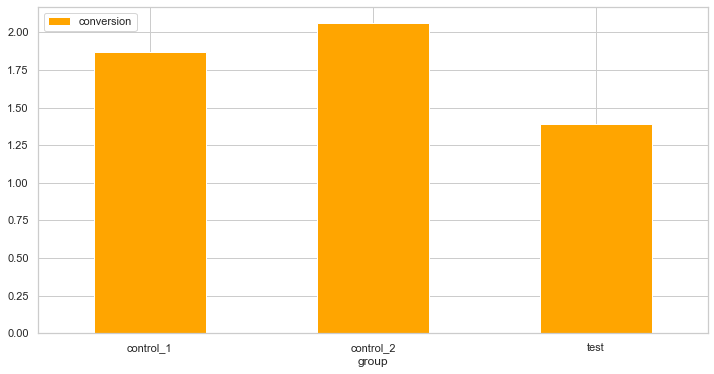

In [35]:
df.conversion.plot.bar(color = "orange", rot=0).legend(loc=2) 

Конверсия в тестовой группе статистически значимо ниже, чем в контрольных

Проверю, есть ли разница в конверсии у пользователей в зависимости от разных параметров. Для этого воспользуюсь датасетами из предыдущей части.


In [36]:
conv_test = premium_test.merge(users_test[['uid','age', 'attraction_coeff', 'country', 'gender']], on='uid')
conv_ctrl_1 = premium_ctrl_1.merge(users_conrol_1[['uid','age', 'attraction_coeff', 'country', 'gender']], on='uid')
conv_ctrl_2 = premium_ctrl_2.merge(users_conrol_2[['uid','age', 'attraction_coeff', 'country', 'gender']], on='uid')

In [37]:
conv_test.is_premium_no_trial = conv_test.is_premium_no_trial.apply(lambda x: 1 if x =="yes" else 0)
conv_ctrl_1.is_premium_no_trial = conv_ctrl_1.is_premium_no_trial.apply(lambda x: 1 if x =="yes" else 0)
conv_ctrl_2.is_premium_no_trial = conv_ctrl_2.is_premium_no_trial.apply(lambda x: 1 if x =="yes" else 0)

In [38]:
conv_total = pd.concat([conv_test, conv_ctrl_1, conv_ctrl_2])

In [39]:
# Функция для расчета конверсии

def cnv(c):
    return (100 * c.sum()/c.count()).round(2)

In [40]:
cnv(conv_test.is_premium_no_trial)

1.39

In [41]:
conv_total.head()

,uid,is_premium_no_trial,group,age,attraction_coeff,country,gender
0,891051147,0,test,21,333,United States of America,1
1,891052710,0,test,26,1000,United States of America,1
2,891053094,0,test,28,666,Argentina,1
3,891054294,0,test,24,0,Italy,1
4,891054594,0,test,28,1000,United States of America,1


In [42]:
# конверсия по странам
conv_total.pivot_table(index = 'country' , columns = 'group', values='is_premium_no_trial', aggfunc=cnv).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
country,,,
Mexico,0.00,0.00,14.29
United Arab Emirates,1.45,1.90,2.65
United Kingdom (Great Britain),2.05,4.79,2.37
Canada,2.24,0.00,2.19
Spain,1.46,2.90,1.99
Israel,8.26,2.56,1.89
Italy,2.96,1.37,1.86
Australia,2.00,0.00,1.61
Chile,1.39,2.10,1.47


In [43]:
# в тестовой группе выше конверсия в Мексике и ОАЭ - проверим эти страны

In [44]:
# Выборка пользователей из Мексики слишком мала и нерепрезентативна
conv_total[conv_total.country == 'Mexico']

,uid,is_premium_no_trial,group,age,attraction_coeff,country,gender
326,891173295,0,test,49,352,Mexico,1
1230,891399054,0,test,42,0,Mexico,1
1262,891406239,0,test,32,583,Mexico,1
2445,891846402,0,test,21,500,Mexico,1
3097,892056582,0,test,18,131,Mexico,1
3247,892098222,0,test,32,0,Mexico,1
3764,892275204,1,test,20,245,Mexico,1
87,891077976,0,control_1,37,0,Mexico,1
695,891273003,0,control_1,36,1000,Mexico,1
4042,892344111,0,control_1,24,0,Mexico,1


In [45]:
# Пользователей в ОАЭ достаточно много. Проверим, отличается ли для них конверсия статистически значимо
conv_total[conv_total.country == 'United Arab Emirates']

,uid,is_premium_no_trial,group,age,attraction_coeff,country,gender
15,891057915,0,test,37,333,United Arab Emirates,1
18,891058338,0,test,32,500,United Arab Emirates,1
33,891063327,0,test,17,483,United Arab Emirates,1
36,891064587,0,test,25,0,United Arab Emirates,0
39,891066153,0,test,29,409,United Arab Emirates,1
...,...,...,...,...,...,...,...
4157,892397547,0,control_2,32,333,United Arab Emirates,1
4166,892402671,0,control_2,27,888,United Arab Emirates,1
4184,892410111,0,control_2,31,0,United Arab Emirates,1
4192,892414974,0,control_2,59,576,United Arab Emirates,1


In [46]:
cnv_for_uae = conv_total.query('country == "United Arab Emirates"')

In [47]:
stat, p, dof, expected = ss.chi2_contingency(pd.crosstab(cnv_for_uae.group, cnv_for_uae.is_premium_no_trial))

prob = 0.95
alpha = 1.0 - prob
print ('хи-квадрат = ', stat, ' p = ', p)
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

хи-квадрат =  0.8179101485274403  p =  0.6643440777986349
Не отклоняем H0


Разница конверсии в ОАЭ по сравнению с остальными странами не оказалась значимой

In [48]:
# конверсия по полу - в тестовой группе лучше не стало
conv_total.pivot_table(index = 'gender' , columns = 'group', values='is_premium_no_trial', aggfunc=cnv).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
gender,,,
1,1.95,2.06,1.46
0,0.00,2.05,0.00


Посмотрим на конверсию в зависимости от возраста и коэф. привлекательности

In [49]:
conv_total.describe()

,uid,is_premium_no_trial,age,attraction_coeff,gender
count,1.291200e+04,12912.000000,12912.000000,12912.000000,12912.000000
mean,8.917569e+08,0.017735,32.010378,315.455545,0.955158
std,1.610285e+06,0.131993,10.224415,323.488766,0.206965
min,8.910509e+08,0.000000,16.000000,0.000000,0.000000
25%,8.913565e+08,0.000000,25.000000,0.000000,1.000000
50%,8.917255e+08,0.000000,30.000000,250.000000,1.000000
75%,8.920860e+08,0.000000,38.000000,529.000000,1.000000
max,1.053059e+09,1.000000,99.000000,1000.000000,1.000000


In [50]:
# создам когорты по полу и по привлекательности

In [51]:
conv_total['age_cohort'] = pd.cut(conv_total.age, [0, 25, 30, 38, 100], right=False, labels = ["<25", "25-29", "30-37", "38+"])

In [52]:
conv_total['attr_cohort'] = pd.cut(conv_total.attraction_coeff, [0, 250, 529, 1001], right=False, labels=["low", "medium", "high"])

In [53]:
conv_total.head()

,uid,is_premium_no_trial,group,age,attraction_coeff,country,gender,age_cohort,attr_cohort
0,891051147,0,test,21,333,United States of America,1,<25,medium
1,891052710,0,test,26,1000,United States of America,1,25-29,high
2,891053094,0,test,28,666,Argentina,1,25-29,high
3,891054294,0,test,24,0,Italy,1,<25,low
4,891054594,0,test,28,1000,United States of America,1,25-29,high


In [54]:
# конверсия по возрасту - в тестовой группе везде ниже, чем в контрольных
conv_total.pivot_table(index = 'age_cohort' , columns = 'group', values='is_premium_no_trial', aggfunc=cnv).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
age_cohort,,,
30-37,1.38,1.76,1.78
<25,2.02,2.37,1.59
38+,1.86,1.84,1.16
25-29,2.26,2.32,1.04


In [55]:
# По привлекательности
conv_total.pivot_table(index = 'attr_cohort' , columns = 'group', values='is_premium_no_trial', aggfunc=cnv).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
attr_cohort,,,
medium,3.33,3.48,2.12
high,1.40,1.63,1.42
low,1.37,1.60,0.99


В тестовой группе конверсия стала ниже во всех подгруппах

### 4. Расчет ARPU (Average Revenue Per User)

буду использовать тесты Краскела-Уоллеса и Манна-Уитни

In [61]:
print ('ARPU in test group ', users_test.total_revenue.mean())
print ('ARPU in control_1 group ', users_conrol_1_cl.total_revenue.mean())
print ('ARPU in control_2 group ', users_conrol_2.total_revenue.mean())

ARPU in test group  534.0803156917364
ARPU in control_1 group  482.81562572021204
ARPU in control_2 group  450.3841463414634


ARPU значительно отличается в группах. Проверим, насколько это статистически значимо

In [64]:
data_test = users_test.total_revenue/users_test.total_revenue.count()
data1 = users_conrol_1_cl.total_revenue/users_conrol_1_cl.total_revenue.count()
data2 = users_conrol_2.total_revenue/users_conrol_2.total_revenue.count()

In [65]:
# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(data_test, data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=6.888, p=0.032
Different distributions (reject H0)


тест Краскалла-Уоллеса указывает на то, что в группах есть статистически значимые различия по ARPU. Ниже проведу попарно тесты Манна-Уитни, чтобы увидеть, какие группы отличаются друг от друга

In [121]:
# U-тест Манна-Уитни
# H0: Распределения выборки равны.
# H1: Распределения выборки не равны.

# Mann-Whitney U test
# compare samples
print ('Control_1 & Control_2')
stat, p = ss.mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Control_1 & Control_2
Statistics=9252390.000, p=0.968
Same distribution (fail to reject H0)


In [122]:
# U-тест Манна-Уитни
# H0: Распределения выборки равны.
# H1: Распределения выборки не равны.

# Mann-Whitney U test
# compare samples
print ('Test & Control_1')
stat, p = ss.mannwhitneyu(data_test, data1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Test & Control_1
Statistics=9255138.000, p=0.019
Different distribution (reject H0)


In [123]:
# U-тест Манна-Уитни
# H0: Распределения выборки равны.
# H1: Распределения выборки не равны.

# Mann-Whitney U test
# compare samples
print ('Test & Control_2')
stat, p = ss.mannwhitneyu(data_test, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Test & Control_2
Statistics=9096560.000, p=0.022
Different distribution (reject H0)


По результатам тестов Краскела-Уоллиса и Манна-Уитни мы можем принять гипотезу о том, что ARPU тестовой группы статистически значимо отклоняется от контрольных

Посчитаем ARPU для отдельных групп пользователей

In [124]:
arpu(users_test.total_revenue)

534.08

In [126]:
# Собираю удобные датафреймы

df_arpu_t = users_test[['uid', 'age','country', 'gender', 'attraction_coeff', 'views_count', 'total_revenue']].copy()
df_arpu_t['group'] = 'test'

df_arpu_c1 = users_conrol_1_cl[['uid', 'age','country', 'gender', 'attraction_coeff', 'views_count', 'total_revenue']].copy()
df_arpu_c1['group'] = 'control_1'

df_arpu_c2 = users_conrol_2[['uid', 'age','country', 'gender', 'attraction_coeff', 'views_count', 'total_revenue']].copy()
df_arpu_c2['group'] = 'control_2'

In [128]:
df_arpu_t.head()

,uid,age,country,gender,attraction_coeff,views_count,total_revenue,group
0,892309896,27,United States of America,1,685,89,0,test
1,892044516,27,Germany,1,0,0,0,test
2,892185708,45,Israel,1,44,68,0,test
3,892130292,32,United States of America,1,0,0,0,test
4,891406035,27,France,1,1000,1,0,test


In [129]:
df_arpu_total = pd.concat([df_arpu_t, df_arpu_c1, df_arpu_c2])

In [130]:
df_arpu_total

,uid,age,country,gender,attraction_coeff,views_count,total_revenue,group
0,892309896,27,United States of America,1,685,89,0,test
1,892044516,27,Germany,1,0,0,0,test
2,892185708,45,Israel,1,44,68,0,test
3,892130292,32,United States of America,1,0,0,0,test
4,891406035,27,France,1,1000,1,0,test
...,...,...,...,...,...,...,...,...
4259,891937401,63,Italy,1,242,33,0,control_2
4260,891692844,35,France,1,500,2,0,control_2
4261,891096429,41,United States of America,1,333,6,0,control_2
4262,891697584,48,United Kingdom (Great Britain),1,210,19,0,control_2


In [131]:
# arpu по странам
df_arpu_total.pivot_table(index = 'country' , columns = 'group', values='total_revenue', 
                          aggfunc=arpu).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
country,,,
Turkey,9959.625,2340.000,1833.000
Spain,289.649,625.090,948.266
United Arab Emirates,364.942,555.180,945.951
Israel,1086.156,883.667,894.425
Mexico,0.000,0.000,887.714
France,498.251,396.465,706.454
Belgium,422.500,1224.600,681.370
Switzerland,632.667,802.657,635.886
United States of America,485.171,393.141,497.819


В странах, где ARPU тестовой группы выше, проверю его статистически

- Spain
- United Arab Emirates	
- Mexico
- France
- United States of America
- Argentina
- Germany

In [133]:
df_arpu_total.query('country == "Spain"').count()

uid                 953
age                 953
country             953
gender              953
attraction_coeff    953
views_count         953
total_revenue       953
group               953
dtype: int64

In [134]:
country = "Spain"
dt = df_arpu_t.query('country == @country').total_revenue/df_arpu_t.query('country == @country').total_revenue.count()
d1 = df_arpu_c1.query('country == @country').total_revenue/df_arpu_c1.query('country == @country').total_revenue.count()
d2 = df_arpu_c2.query('country == @country').total_revenue/df_arpu_c2.query('country == @country').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(country)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Spain
Statistics=2.497, p=0.287
Same distributions (fail to reject H0)


In [135]:
df_arpu_total.query('country == "United Arab Emirates"').count()

uid                 644
age                 644
country             644
gender              644
attraction_coeff    644
views_count         644
total_revenue       644
group               644
dtype: int64

In [136]:
country = "United Arab Emirates"
dt = df_arpu_t.query('country == @country').total_revenue/df_arpu_t.query('country == @country').total_revenue.count()
d1 = df_arpu_c1.query('country == @country').total_revenue/df_arpu_c1.query('country == @country').total_revenue.count()
d2 = df_arpu_c2.query('country == @country').total_revenue/df_arpu_c2.query('country == @country').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(country)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

United Arab Emirates
Statistics=0.913, p=0.634
Same distributions (fail to reject H0)


In [137]:
df_arpu_total.query('country == "Mexico"').count() 
# В Мексике недостаточная выборка

uid                 15
age                 15
country             15
gender              15
attraction_coeff    15
views_count         15
total_revenue       15
group               15
dtype: int64

In [138]:
df_arpu_total.query('country == "France"').count() 

uid                 1105
age                 1105
country             1105
gender              1105
attraction_coeff    1105
views_count         1105
total_revenue       1105
group               1105
dtype: int64

In [139]:
country = "France"
dt = df_arpu_t.query('country == @country').total_revenue/df_arpu_t.query('country == @country').total_revenue.count()
d1 = df_arpu_c1.query('country == @country').total_revenue/df_arpu_c1.query('country == @country').total_revenue.count()
d2 = df_arpu_c2.query('country == @country').total_revenue/df_arpu_c2.query('country == @country').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(country)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

France
Statistics=1.888, p=0.389
Same distributions (fail to reject H0)


In [140]:
df_arpu_total.query('country == "United States of America"').count() 

uid                 4407
age                 4407
country             4407
gender              4407
attraction_coeff    4407
views_count         4407
total_revenue       4407
group               4407
dtype: int64

In [141]:
country = "United States of America"
dt = df_arpu_t.query('country == @country').total_revenue/df_arpu_t.query('country == @country').total_revenue.count()
d1 = df_arpu_c1.query('country == @country').total_revenue/df_arpu_c1.query('country == @country').total_revenue.count()
d2 = df_arpu_c2.query('country == @country').total_revenue/df_arpu_c2.query('country == @country').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(country)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

United States of America
Statistics=0.827, p=0.661
Same distributions (fail to reject H0)


In [142]:
df_arpu_total.query('country == "Argentina"').count() 

uid                 1182
age                 1182
country             1182
gender              1182
attraction_coeff    1182
views_count         1182
total_revenue       1182
group               1182
dtype: int64

In [143]:
country = "Argentina"
dt = df_arpu_t.query('country == @country').total_revenue/df_arpu_t.query('country == @country').total_revenue.count()
d1 = df_arpu_c1.query('country == @country').total_revenue/df_arpu_c1.query('country == @country').total_revenue.count()
d2 = df_arpu_c2.query('country == @country').total_revenue/df_arpu_c2.query('country == @country').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(country)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Argentina
Statistics=1.415, p=0.493
Same distributions (fail to reject H0)


In [144]:
df_arpu_total.query('country == "Germany"').count() 

uid                 599
age                 599
country             599
gender              599
attraction_coeff    599
views_count         599
total_revenue       599
group               599
dtype: int64

In [145]:
country = "Germany"
dt = df_arpu_t.query('country == @country').total_revenue/df_arpu_t.query('country == @country').total_revenue.count()
d1 = df_arpu_c1.query('country == @country').total_revenue/df_arpu_c1.query('country == @country').total_revenue.count()
d2 = df_arpu_c2.query('country == @country').total_revenue/df_arpu_c2.query('country == @country').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(country)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Germany
Statistics=0.315, p=0.854
Same distributions (fail to reject H0)


ARPU по странам в тестовой и контрольных группах значимо не различаются

In [146]:
# arpu по полу
df_arpu_total.pivot_table(index = 'gender' , columns = 'group', values='total_revenue', 
                          aggfunc=arpu).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
gender,,,
1,493.031,461.927,553.760
0,249.500,209.533,134.054


In [147]:
gender = 1
dt = df_arpu_t.query('gender == @gender').total_revenue/df_arpu_t.query('gender == @gender').total_revenue.count()
d1 = df_arpu_c1.query('gender == @gender').total_revenue/df_arpu_c1.query('gender == @gender').total_revenue.count()
d2 = df_arpu_c2.query('gender == @gender').total_revenue/df_arpu_c2.query('gender == @gender').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print('Мужчины')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Мужчины
Statistics=5.790, p=0.055
Same distributions (fail to reject H0)


In [148]:
gender = 0
dt = df_arpu_t.query('gender == @gender').total_revenue/df_arpu_t.query('gender == @gender').total_revenue.count()
d1 = df_arpu_c1.query('gender == @gender').total_revenue/df_arpu_c1.query('gender == @gender').total_revenue.count()
d2 = df_arpu_c2.query('gender == @gender').total_revenue/df_arpu_c2.query('gender == @gender').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print('Женщины')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Женщины
Statistics=2.948, p=0.229
Same distributions (fail to reject H0)


In [149]:
# Создаю возрастные когорты

df_arpu_total['age_cohort'] = pd.cut(df_arpu_total.age, [0, 25, 30, 38, 100], right=False, labels = ["<25", "25-29", "30-37", "38+"])
df_arpu_t['age_cohort'] = pd.cut(df_arpu_t.age, [0, 25, 30, 38, 100], right=False, labels = ["<25", "25-29", "30-37", "38+"])
df_arpu_c1['age_cohort'] = pd.cut(df_arpu_c1.age, [0, 25, 30, 38, 100], right=False, labels = ["<25", "25-29", "30-37", "38+"])
df_arpu_c2['age_cohort'] = pd.cut(df_arpu_c2.age, [0, 25, 30, 38, 100], right=False, labels = ["<25", "25-29", "30-37", "38+"])

In [150]:
df_arpu_t.head()

,uid,age,country,gender,attraction_coeff,views_count,total_revenue,group,age_cohort
0,892309896,27,United States of America,1,685,89,0,test,25-29
1,892044516,27,Germany,1,0,0,0,test,25-29
2,892185708,45,Israel,1,44,68,0,test,38+
3,892130292,32,United States of America,1,0,0,0,test,30-37
4,891406035,27,France,1,1000,1,0,test,25-29


In [151]:
# arpu по возрасту
df_arpu_total.pivot_table(index = 'age_cohort' , columns = 'group', values='total_revenue', 
                          aggfunc=arpu).dropna()\
        .sort_values('test', ascending = False)

group,control_1,control_2,test
age_cohort,,,
30-37,381.985,456.895,608.799
38+,437.996,513.420,606.864
<25,497.304,377.307,468.524
25-29,633.970,448.736,447.309


In [154]:
age_cohort = '<25'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(age_cohort)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

<25
Statistics=5.551, p=0.062
Same distributions (fail to reject H0)


ARPU в когорте 25-29 лет имеет значимые отличия между одной или несколькими группами, но не в пользу тестовой

In [155]:
age_cohort = '25-29'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(age_cohort)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

25-29
Statistics=14.331, p=0.001
Different distributions (reject H0)


In [152]:
age_cohort = '30-37'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(age_cohort)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

30-37
Statistics=1.148, p=0.563
Same distributions (fail to reject H0)


In [153]:
age_cohort = '38+'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print(age_cohort)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

38+
Statistics=1.218, p=0.544
Same distributions (fail to reject H0)


Т.к. статистически значимые различия были обнаружены только в когорте 25-29 лет, попробую провести тест без нее 

In [170]:
age_cohort = '25-29'
dt = df_arpu_t.query('age_cohort != @age_cohort').total_revenue/df_arpu_t.query('age_cohort != @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort != @age_cohort').total_revenue/df_arpu_c1.query('age_cohort != @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort != @age_cohort').total_revenue/df_arpu_c2.query('age_cohort != @age_cohort').total_revenue.count()

# Kruskal-Wallis H Test
# H0: Все примеры распределений одинаковы.
# H1: Одно или несколько примеров распределений не равны

# compare samples
stat, p = ss.kruskal(dt, d1, d2)
print('not ', age_cohort)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

not  25-29
Statistics=1.942, p=0.379
Same distributions (fail to reject H0)


Видимо, именно эта когорта давала статистически значимые различия.
Проверю ниже:

In [181]:
# U-тест Манна-Уитни
# H0: Распределения выборки равны.
# H1: Распределения выборки не равны.

age_cohort = '25-29'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()


# Mann-Whitney U test
# compare samples
print ('Test & Control_1')
stat, p = ss.mannwhitneyu(dt, d1)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Test & Control_1
Statistics=495650.500, p=0.000
Different distribution (reject H0)


In [185]:
# U-тест Манна-Уитни
# H0: Распределения выборки равны.
# H1: Распределения выборки не равны.

age_cohort = '25-29'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()


# Mann-Whitney U test
# compare samples
print ('Test & Control_2')
stat, p = ss.mannwhitneyu(dt, d2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Test & Control_2
Statistics=511683.500, p=0.022
Different distribution (reject H0)


In [184]:
# U-тест Манна-Уитни
# H0: Распределения выборки равны.
# H1: Распределения выборки не равны.

age_cohort = '25-29'
dt = df_arpu_t.query('age_cohort == @age_cohort').total_revenue/df_arpu_t.query('age_cohort == @age_cohort').total_revenue.count()
d1 = df_arpu_c1.query('age_cohort == @age_cohort').total_revenue/df_arpu_c1.query('age_cohort == @age_cohort').total_revenue.count()
d2 = df_arpu_c2.query('age_cohort == @age_cohort').total_revenue/df_arpu_c2.query('age_cohort == @age_cohort').total_revenue.count()


# Mann-Whitney U test
# compare samples
print ('Control_1 & Control_2')
stat, p = ss.mannwhitneyu(d1, d2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Control_1 & Control_2
Statistics=489631.500, p=0.117
Same distribution (fail to reject H0)


### 5. Выводы

Результаты эксперимента были проанализированы в разрезе двух метрик: ARPU и конверсии. 

По результатам анализа можно сказать, что эксперимент не был успешен. Конверсия в тестовой группе снизилась на ~0.5% относительно контрольных групп. Снижение наблюдается для всех подгрупп пользователей.

Может показаться, что ARPU в тестовой грппе вырос по отношению к контрольным, но эти показатели оказались статистически не значимы. По метрике ARPU значимые различия между тестовой и контрольными группами были зафиксированы только для пользователей в возрасте 25-29 лет: для этих пользователей ARPU в тестовой группе снизился.

Также выявлено, что исследуемые метрики значительно не менялись в зависимости от страны, пола или коэффициента привлекательности пользователей.

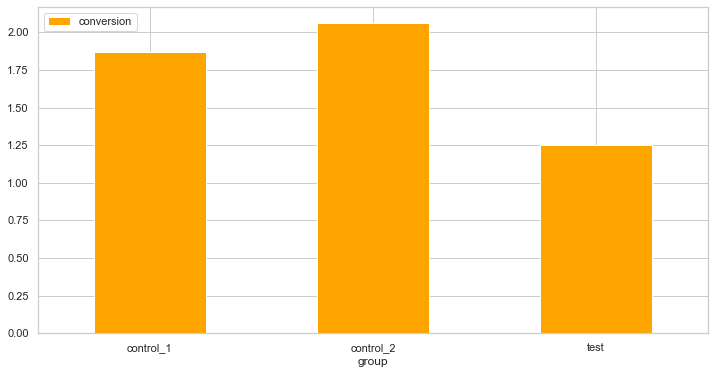

In [222]:
df.conversion.plot.bar(color = "orange", rot=0).legend(loc=2) 